In [1]:
from IPython.display import Image

# 7장 다양한 모델을 결합한 앙상블 학습

## 7.1 앙상블 학습

In [2]:
Image(url='https://git.io/JtskW', width=500) 

In [3]:
Image(url='https://git.io/Jtskl', width=500) 

이진 분류 작업에 대한 동일한 에러율 $\epsilon$을 가진 n개의 분류기가 있다. 모든 분류기는 독립적이고 발생하는 오차는 서로 상관관계가 없다고 가정하자. 이런 가정 하에 이 분류기의 앙상블이 만드는 오차 확률을 이항 분포의 확률 질량 함수로 표현할 수 있다:

$$P(y \geq k) = \sum_k^n \left \langle \begin{matrix}
n\\ k \end{matrix} \right \rangle \epsilon^k (1-\epsilon)^{n-k} =\epsilon_{ensemble}$$

In [4]:
import numpy as np
from scipy.special import comb

def ensemble_error(n_classifier, error):
    k_start = int(np.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) * error**k * (1 - error)**(n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

In [5]:
from scipy.stats import binom

binom.cdf(5, 11, 0.75)

0.03432750701904298

---

In [6]:
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
              for error in error_range]

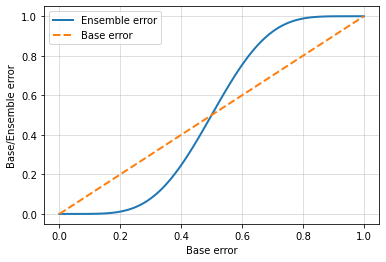

In [7]:
import matplotlib.pyplot as plt

plt.plot(error_range, 
         ens_errors, 
         label='Ensemble error', 
         linewidth=2)

plt.plot(error_range, 
         error_range, 
         linestyle='--',
         label='Base error',
         linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

## 7.2 다수결 투표를 사용한 분류 앙상블

### 간단한 다수결 투표 분류기 구현

\begin{align*}
\hat{y} &= \text{arg}\underset{i}{\text{max}} \sum_{j=1}^m w_j \chi_A\left(C_j(\mathbf{x})=i \right )\\ 
 &\Downarrow {\scriptsize\text{가중치가 동일할 때}} \\
\hat{y} &= \text{mode} \{ C_1(\mathbf{x}), C_2(\mathbf{x}), \cdots, C_m(\mathbf{x})\}
\end{align*}

In [8]:
np.argmax(np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6]))

1

$$\hat{y} = \text{arg}\underset{i}{\text{max}} \sum_{j=1}^m w_j p_{ij}$$

In [9]:
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])

p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [10]:
np.argmax(p)

0

---

In [11]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """다수결 투표 앙상블 분류기

    매개변수
    ----------
    classifiers : 배열 타입, 크기 = [n_classifiers]
        앙상블에 사용할 분류기
    
    vote : str, {'classlabel', 'probability'}
        기본값: 'classlabel'
        'classlabel'이면 예측은 다수인 클래스 레이블의 인덱스가 됩니다
        'probability'면 확률 합이 가장 큰 인덱스로
        클래스 레이블을 예측합니다(보정된 분류기에 추천합니다)
    
    weights : 배열 타입, 크기 = [n_classifiers]
        선택 사항, 기본값: None
        'int' 또는 'float' 값의 리스트가 주어지면 분류기가 이 중요도로 가중치됩니다
        'weights=None'이면 동일하게 취급합니다

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """분류기를 학습합니다

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            훈련 샘플 행렬
        
        y : 배열 타입, 크기 = [n_samples]
            타깃 클래스 레이블 벡터
            
        반환값
        -------
        self : 객체
        
        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote는 'probability' 또는 'classlabel'이어야 합니다"
                             "; (vote=%r)이 입력되었습니다."
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('분류기와 가중치 개수는 같아야 합니다'
                             '; 가중치 %d 개, 분류기 %d 개'
                             % (len(self.weights), len(self.classifiers)))

        # self.predict 메서드에서 np.argmax를 호출할 때
        # 클래스 레이블이 0부터 시작되어야 하므로 LabelEncoder를 사용합니다
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """X에 대한 클래스 레이블을 예측합니다

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            샘플 데이터 행렬
        
        반환값
        ----------
        maj_vote : 배열 타입, 크기 = [n_samples]
            예측된 클래스 레이블
        
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' 투표

            # clf.predict 메서드를 사용하여 결과를 모읍니다
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """X에 대한 클래스 확률을 예측합니다

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            n_samples는 샘플의 개수고 n_features는 특성의 개수인
            샘플 데이터 행렬
        
        반환값
        ----------
        avg_proba : 배열 타입,
            크기 = [n_samples, n_classes]
            샘플마다 가중치가 적용된 클래스의 평균 확률
        
        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """GridSearch를 위해 분류기의 매개변수 이름을 반환합니다"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value
            return out

### 다수결 투표 방식을 사용하여 예측 만들기

In [12]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

---

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-겹 교차 검증:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-겹 교차 검증:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [14]:
# 다수결 (하드) 투표

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


사이킷런의 VotingClassifier를 사용해 보겠습니다. estimators 매개변수에는 분류기 이름과 객체로 구성된 튜플의 리스트를 입력합니다. 앞에서 만든 MajorityVoteClassifier는 vote 매개변수에 상관없이 predict_proba 메서드를 실행할 수 있지만 사이킷런의 VotingClassifier는 voting='hard'일 경우 predict_proba 메서드를 지원하지 않습니다. ROC AUC를 계산하기 위해서는 예측 확률이 필요하므로 voting='soft'로 지정합니다.

In [15]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(estimators=[('lr', pipe1), ('dt', clf2), ('knn', pipe3)], voting='soft')

scores = cross_validate(estimator=vc, X=X_train, y=y_train, cv=10, scoring='roc_auc')
print("ROC AUC: : %0.2f (+/- %0.2f) [%s]"
      % (scores['test_score'].mean(), 
         scores['test_score'].std(), 'VotingClassifier'))

ROC AUC: : 0.98 (+/- 0.05) [VotingClassifier]


In [16]:
vc.set_params(verbose=True)

vc = vc.fit(X_train, y_train)

[Voting] ....................... (1 of 3) Processing lr, total=   0.0s
[Voting] ....................... (2 of 3) Processing dt, total=   0.0s
[Voting] ...................... (3 of 3) Processing knn, total=   0.0s


In [17]:
vc.predict_proba(X_test[:10])

array([[0.80858947, 0.19141053],
       [0.80798659, 0.19201341],
       [0.80742142, 0.19257858],
       [0.81176637, 0.18823363],
       [0.81195778, 0.18804222],
       [0.17701319, 0.82298681],
       [0.17670572, 0.82329428],
       [0.17845724, 0.82154276],
       [0.1796252 , 0.8203748 ],
       [0.81076201, 0.18923799]])

### 앙상블 분류기의 평가와 튜닝

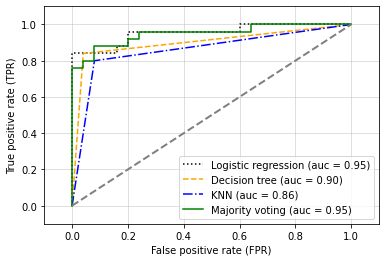

In [18]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']


for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    
    plt.plot(fpr, tpr, color=clr, ls=ls, label='%s (auc = %0.2f)' % (label, roc_auc))
    
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], ls='--', color='gray', lw=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

---

In [19]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

In [20]:
from itertools import product

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))

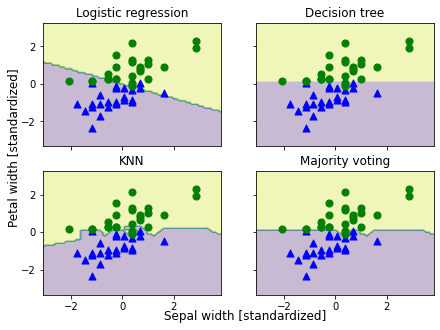

In [21]:
f, axarr = plt.subplots(nrows=2, ncols=2,
                       sharex='col',
                       sharey='row',
                       figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                  X_train_std[y_train==0, 1],
                                  c='blue',
                                  marker='^',
                                  s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                  X_train_std[y_train==1, 1],
                                  c='green',
                                  marker='o',
                                  s=50)
    axarr[idx[0], idx[1]].set_title(tt)
    
plt.text(-3.5, -4.5,
        s='Sepal width [standardized]',
        ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5,
        s='Petal width [standardized]',
        ha='center', va='center', fontsize=12, rotation=90)

plt.show()

In [22]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

---

In [23]:
from sklearn.model_selection import GridSearchCV

params = {'decisiontreeclassifier__max_depth': [1, 2],
         'pipeline-1__clf__C': [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=mv_clf,
                   param_grid=params,
                   cv=10,
                   scoring='roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.001,
                                                                                               random_state=1)]]),
                                                           DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=1,
                                                                                  random_state=0),
                                                           Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                           

In [24]:
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print('%0.3f +/- %0.2f %r' % (grid.cv_results_['mean_test_score'][r],
                                 grid.cv_results_['std_test_score'][r] / 2,
                                 grid.cv_results_['params'][r]))

0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [25]:
print('최적의 매개변수: %s' % grid.best_params_)

최적의 매개변수: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}


In [26]:
print('정확도: %0.2f' % grid.best_score_)

정확도: 0.98


---

In [27]:
from sklearn.ensemble import StackingClassifier

stack = StackingClassifier(estimators=[
                           ('lr', pipe1), ('dt', clf2), ('knn', pipe3)],
                           final_estimator=LogisticRegression())


In [28]:
params = {'dt__max_depth': [1, 2],
         'lr__clf__C': [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=stack,
                   param_grid=params,
                   cv=10,
                   scoring='roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=StackingClassifier(estimators=[('lr',
                                                       Pipeline(steps=[('sc',
                                                                        StandardScaler()),
                                                                       ['clf',
                                                                        LogisticRegression(C=0.001,
                                                                                           random_state=1)]])),
                                                      ('dt',
                                                       DecisionTreeClassifier(criterion='entropy',
                                                                              max_depth=1,
                                                                              random_state=0)),
                                                      ('knn',
                                                  

In [29]:
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print('%0.3f +/- %0.2f %r' % (grid.cv_results_['mean_test_score'][r],
                                 grid.cv_results_['std_test_score'][r] / 2,
                                 grid.cv_results_['params'][r]))

0.950 +/- 0.07 {'dt__max_depth': 1, 'lr__clf__C': 0.001}
0.983 +/- 0.02 {'dt__max_depth': 1, 'lr__clf__C': 0.1}
0.967 +/- 0.05 {'dt__max_depth': 1, 'lr__clf__C': 100.0}
0.950 +/- 0.07 {'dt__max_depth': 2, 'lr__clf__C': 0.001}
0.983 +/- 0.02 {'dt__max_depth': 2, 'lr__clf__C': 0.1}
0.967 +/- 0.05 {'dt__max_depth': 2, 'lr__clf__C': 100.0}


In [30]:
print('최적의 매개변수: %s' % grid.best_params_)

최적의 매개변수: {'dt__max_depth': 1, 'lr__clf__C': 0.1}


In [31]:
print('정확도: %0.2f' % grid.best_score_)

정확도: 0.98


## 7.3 배깅: 부트스트랩 샘플링을 통한 분류 앙상블

In [32]:
Image(url='https://git.io/Jtsk4', width=500)

In [33]:
Image(url='https://git.io/JtskB', width=400)

### 배깅으로 Wine 데이터세의 샘플 분류

In [34]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                     'machine-learning-databases/wine/wine.data',
                     header=None)

In [35]:
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                  'Alcalinity of ash', 'Magnesium', 'Total phenols',
                  'Flavanoids', 'Nonflavanoid phenols',
                  'Proanthocyanins', 'Color intensity', 'Hue',
                  '0D280/0D315 of diluted wines', 'Proline']
df_wine = df_wine[df_wine['Class label'] != 1]

In [36]:
X = df_wine[['Alcohol','0D280/0D315 of diluted wines' ]].values
y = df_wine['Class label'].values

In [37]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=1,
                                                   stratify=y)

---

In [38]:
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                             random_state=1,
                             max_depth=None)

bag = BaggingClassifier(base_estimator=tree,
                       n_estimators=500,
                       max_samples=1.0,
                       max_features=1.0,
                       bootstrap=True,
                       bootstrap_features=False,
                       n_jobs=1,
                       random_state=1)

In [39]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print('결정 트리의 훈련 정확도/테스트 정확도 %.3f/%.3f' % (tree_train, tree_test))

결정 트리의 훈련 정확도/테스트 정확도 1.000/0.833


In [40]:
bag = bag.fit(X_train, y_train)

y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)

print('배깅의 훈련 정확도/테스트 정확도 %.3f/%.3f' % (bag_train, bag_test))

배깅의 훈련 정확도/테스트 정확도 1.000/0.917


---

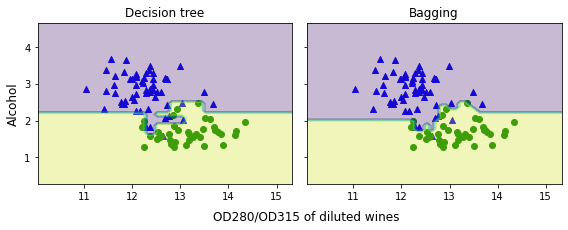

In [41]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1

y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2,
                       sharex='col',
                       sharey='row',
                       figsize=(8, 3))

for idx, clf, tt in zip([0, 1],
                       [tree, bag],
                       ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)    
    
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

plt.show()    

---

In [42]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(oob_score=True, random_state=1)
rf.fit(X_train, y_train)

print('랜덤 포레스트의 훈련 정확도/테스트 정확도 %.3f/%.3f' % (rf.score(X_train, y_train), rf.score(X_test, y_test)))
print('랜덤 포레스트의 OOB 정확도 %.3f' % rf.oob_score_)

랜덤 포레스트의 훈련 정확도/테스트 정확도 1.000/0.917
랜덤 포레스트의 OOB 정확도 0.884


In [43]:
bag = BaggingClassifier(base_estimator=tree,
                       n_estimators=500,
                       oob_score=True,
                       random_state=1)
bag.fit(X_train, y_train)

print('배깅의 훈련 정확도/테스트 정확도 %.3f/%.3f' % (bag.score(X_train, y_train), bag.score(X_test, y_test)))
print('배깅의 OOB 정확도 %.3f' % bag.oob_score_)

배깅의 훈련 정확도/테스트 정확도 1.000/0.917
배깅의 OOB 정확도 0.895


## 7.4 약한 학습기를 이용한 에이다부스트

### 부스팅 작동 원리

In [44]:
Image(url='https://git.io/Jtsk0', width=400)

1. 가중치 백터 $\mathbf{w}$를 동일한 가중치로 설정: $\sum_i w_i = 1$


2. $m$번 부스팅 반복의 $j$번째에서 다음을 수행:


  > 1. 가중치가 부여된 약한 학습기를 훈련: $C_j = \text{train} \left(\mathbf{X}, \mathbf{y}, \mathbf{w} \right)$
  
  > 2. 클래스 레이블을 예측: $\hat{\mathbf{y}}= \text{predict}\left(C_j, \mathbf{X}\right)$
  
  > 3. 가중치가 적용된 에러율 계산: $\epsilon=\mathbf{w}\cdot \left( \hat{\mathbf{y}}\neq\mathbf{y} \ \right)$
  
  > 4. 학습기 가중치 계산: $\displaystyle \alpha_j = 0.5\log \frac{1-\epsilon}{\epsilon}$
  
  > 5. 가중치 업데이트: $\mathbf{w} := \mathbf{w} \,\exp\left( -\alpha_j \times \hat{\mathbf{y}} \times \mathbf{y} \right)$
  
  > 6. 합이 1이 되도록 가중치를 정규화: $\mathbf{w} := \mathbf{w} / \sum_i w_i$
  
3. 최종 예측을 계산: $\hat{\mathbf{y}} = \left( \sum_{j=1}^m \left( \alpha_j \times \text{predict} \left( C_j, \mathbf{X} \right) \right) >0 \right)$

In [45]:
Image(url='https://git.io/Jtskg', width=500)

In [46]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                             random_state=1,
                             max_depth=1)

ada = AdaBoostClassifier(base_estimator=tree,
                        n_estimators=500,
                        learning_rate=0.1,
                        random_state=1)

In [47]:
tree = tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print('결정 트리의 훈련 정확도/테스트 정확도 %.3f/%.3f' % (tree_train, tree_test))

결정 트리의 훈련 정확도/테스트 정확도 0.916/0.875


In [48]:
ada = ada.fit(X_train, y_train)

y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)

print('에이다부스트의 훈련 정확도 %.3f/%.3f' % (ada_train, ada_test))

에이다부스트의 훈련 정확도 1.000/0.917


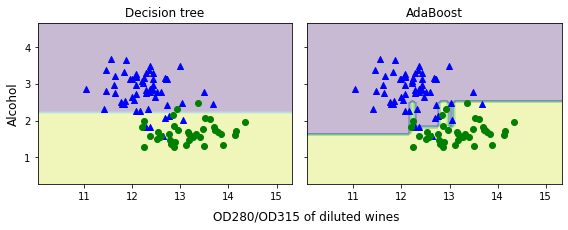

In [49]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

plt.show()

---

In [50]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(n_estimators=20, random_state=42)

gbrt.fit(X_train, y_train)

gbrt_train_score = gbrt.score(X_train, y_train)
gbrt_test_score = gbrt.score(X_test, y_test)

print('그레디언트 부스팅의 훈련 정확도/테스트 정확도 %.3f/%.3f' %(gbrt_train_score, gbrt_test_score))

그레디언트 부스팅의 훈련 정확도/테스트 정확도 1.000/0.917


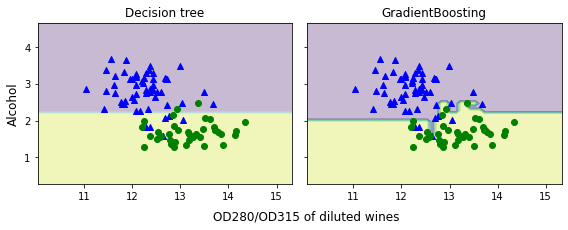

In [51]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, gbrt],
                        ['Decision tree', 'GradientBoosting']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center', va='center', fontsize=12,
         transform=axarr[1].transAxes)

plt.show()

---

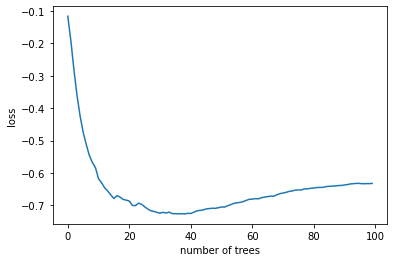

In [52]:
gbrt = GradientBoostingClassifier(n_estimators=100, 
                                  subsample=0.5,
                                  random_state=1)
gbrt.fit(X_train, y_train)
oob_loss = np.cumsum(-gbrt.oob_improvement_)
plt.plot(range(100), oob_loss)
plt.xlabel('number of trees')
plt.ylabel('loss')

plt.show()

In [53]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
 
hgbc = HistGradientBoostingClassifier(random_state=1)
hgbc.fit(X_train, y_train)

hgbc_train_score = gbrt.score(X_train, y_train)
hgbc_test_score = gbrt.score(X_test, y_test)

print('그래디언트 부스팅 훈련 정확도/테스트 정확도 %.3f/%.3f' % (hgbc_train_score, hgbc_test_score))

그래디언트 부스팅 훈련 정확도/테스트 정확도 1.000/0.917


In [54]:
#!conda install -c conda-forge xgboost

In [55]:
from xgboost import XGBClassifier

xgb = XGBClassifier(tree_method='hist', random_state=1, eval_metric='logloss')
xgb.fit(X_train, y_train)

C:\Users\kyyoo\miniconda3\envs\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, random_state=1, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='hist',
              validate_parameters=1, verbosity=None)

In [56]:
xgb_train_score = xgb.score(X_train, y_train)
xgb_test_score = xgb.score(X_test, y_test)

print('XGBoost 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (xgb_train_score, xgb_test_score))

XGBoost 훈련 정확도/테스트 정확도 0.979/0.917


In [57]:
#! conda install -c conda-forge lightgbm

In [58]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=1)
lgb.fit(X_train, y_train)

LGBMClassifier(random_state=1)

In [59]:
lgb_train_score = lgb.score(X_train, y_train)
lgb_test_score = lgb.score(X_test, y_test)

print('LightGBM 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (lgb_train_score, lgb_test_score))

LightGBM 훈련 정확도/테스트 정확도 0.979/0.917
